## Importing the Data

In [ ]:
import os  # Importing the OS module for interacting with the operating system
import pandas as pd  # Importing pandas for data manipulation and analysis

# Load the training dataset from a TSV (tab-separated values) file
X = pd.read_csv('training_set_rel3.tsv', sep='\t', encoding='ISO-8859-1')

# Extract the target variable (domain1_score) from the DataFrame
y = X['domain1_score']

# Drop any columns from the DataFrame that contain only missing values
X = X.dropna(axis=1)

# Drop specific columns that are not needed for the analysis or modeling
# Here, we are removing 'rater1_domain1' and 'rater2_domain1' as they may not be relevant
X = X.drop(columns=['rater1_domain1', 'rater2_domain1'])


In [ ]:
# Display the first 5 rows of the DataFrame to get an overview of the data
X.head()

# Print the total number of rows in the DataFrame
print(len(X))

# Display the last 5 rows of the DataFrame to see the end of the data
X.tail()


12976


,essay_id,essay_set,essay,domain1_score
12971,21626,8,In most stories mothers and daughters are eit...,35
12972,21628,8,I never understood the meaning laughter is th...,32
12973,21629,8,"When you laugh, is @CAPS5 out of habit, or is ...",40
12974,21630,8,Trippin' on fen...,40
12975,21633,8,Many people believe that laughter can improve...,40


Minimum and Maximum Scores for each essay set.

In [ ]:
minimum_scores = [-1, 2, 1, 0, 0, 0, 0, 0, 0]
maximum_scores = [-1, 12, 6, 3, 3, 4, 4, 30, 60]

## Preprocessing the Data

We will preprocess all essays and convert them to feature vectors so that they can be fed into the RNN.

These are all helper functions used to clean the essays.

In [ ]:
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import nltk
import re
import numpy as np
from nltk.corpus import stopwords

def essay_to_sentences(essay_v, remove_stopwords):
    """
    Function to split an essay into a list of sentences, 
    where each sentence is represented as a list of words.

    Parameters:
    essay_v (str): The input essay as a string.
    remove_stopwords (bool): A flag to indicate whether to remove stopwords.

    Returns:
    list: A list of sentences, where each sentence is a list of words.
    """
    # Load NLTK's sentence tokenizer for English
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    
    # Split the essay into a list of sentences
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    
    # Initialize an empty list to hold the tokenized sentences
    sentences = []
    
    # Process each sentence
    for raw_sentence in raw_sentences:
        # Skip empty sentences
        if len(raw_sentence) > 0:
            # Convert the sentence to a list of words
            # Optionally remove stopwords
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))
    
    return sentences

def essay_to_wordlist(essay_v, remove_stopwords):
    """
    Function to convert a text string into a list of words.
    
    Parameters:
    essay_v (str): The input text string.
    remove_stopwords (bool): A flag to indicate whether to remove stopwords.

    Returns:
    list: A list of words after cleaning and optional stopword removal.
    """
    # Use regular expressions to keep only letters (remove punctuation, numbers, etc.)
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    
    # Convert text to lowercase and split into individual words
    words = essay_v.lower().split()
    
    # Optionally remove stopwords
    if remove_stopwords:
        # Load the list of English stopwords from NLTK
        stops = set(stopwords.words("english"))
        # Filter out any stopwords from the list of words
        words = [w for w in words if not w in stops]
    
    return words

def makeFeatureVec(words, model, num_features):
    """
    Function to create a feature vector from a list of words using a Word2Vec model.

    Parameters:
    words (list): A list of words.
    model (Word2Vec): A pre-trained Word2Vec model.
    num_features (int): The number of features in the Word2Vec model.

    Returns:
    np.array: A feature vector representing the average word vectors for the list of words.
    """
    # Initialize a zero vector for the feature vector
    featureVec = np.zeros((num_features,), dtype="float32")
    
    # Variable to keep track of the number of words found in the model's vocabulary
    num_words = 0.0
    
    # Create a set of words in the model's vocabulary for faster lookup
    index2word_set = set(model.wv.index_to_key)  # Corrected to use `index_to_key`
    
    # Iterate through the list of words
    for word in words:
        # If the word is in the model's vocabulary, update the feature vector
        if word in index2word_set:
            num_words += 1
            # Add the word vector to the feature vector
            featureVec = np.add(featureVec, model.wv.get_vector(word))
    
    # Divide the feature vector by the number of words to get the average
    if num_words > 0:
        featureVec = np.divide(featureVec, num_words)
    
    return featureVec

def getAvgFeatureVecs(essays, model, num_features):
    """
    Function to create feature vectors for a list of essays.
    Each essay is converted into an average feature vector of its word vectors.

    Parameters:
    essays (list): A list of essays, where each essay is a list of words.
    model (Word2Vec): A pre-trained Word2Vec model.
    num_features (int): The number of features in the Word2Vec model.

    Returns:
    np.array: An array of feature vectors, one for each essay.
    """
    # Initialize a zero matrix for the feature vectors of all essays
    essayFeatureVecs = np.zeros((len(essays), num_features), dtype="float32")
    
    # Iterate over the essays
    for i, essay in enumerate(essays):
        # Compute the feature vector for each essay
        essayFeatureVecs[i] = makeFeatureVec(essay, model, num_features)
    
    return essayFeatureVecs


## Defining the model

Here we define a 2-Layer LSTM Model.

Note that instead of using sigmoid activation in the output layer we will use
Relu since we are not normalising training labels.

## Training Phase

Now we train the model on the dataset.

We will use 5-Fold Cross Validation and measure the Quadratic Weighted Kappa for each fold.
We will then calculate Average Kappa for all the folds.

In [ ]:
!pip install nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
!pip install keras

In [ ]:
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model
import keras.backend as K
from keras.layers import BatchNormalization
from keras.optimizers import Adam

def get_model_1():
    """
    Define the first model architecture using LSTM layers for sequence prediction.

    The model consists of:
    - Two LSTM layers with dropout and recurrent dropout to prevent overfitting.
    - A Dropout layer for additional regularization.
    - A Dense layer with a ReLU activation function for the final output.
    The model is compiled with 'rmsprop' optimizer and 'mean_squared_error' loss function.
    
    Returns:
    - A compiled Keras Sequential model.
    """
    model = Sequential()
    
    # First LSTM layer with 300 units and dropout for regularization
    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    
    # Second LSTM layer with 64 units; no return_sequences as it's the last LSTM layer
    model.add(LSTM(64, recurrent_dropout=0.4))
    
    # Dropout layer to reduce overfitting
    model.add(Dropout(0.5))
    
    # Dense output layer with ReLU activation for regression output
    model.add(Dense(1, activation='relu'))
    
    # Compile the model with 'rmsprop' optimizer and 'mean_squared_error' loss
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    
    return model

def get_model_2():
    """
    Define a different model architecture using LSTM layers for comparison.

    The model consists of:
    - Two LSTM layers with a lower number of units compared to get_model_1.
    - Dropout layers for regularization.
    - A Dense layer with Leaky ReLU activation for output.
    The model is compiled with 'adam' optimizer and 'mean_squared_error' loss function.
    
    Returns:
    - A compiled Keras Sequential model.
    """
    model = Sequential()
    
    # First LSTM layer with 200 units and dropout for regularization
    model.add(LSTM(200, dropout=0.3, recurrent_dropout=0.3, input_shape=[1, 300], return_sequences=True))
    
    # Second LSTM layer with 100 units; no return_sequences as it's the last LSTM layer
    model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
    
    # Dropout layer to prevent overfitting
    model.add(Dropout(0.4))
    
    # Dense output layer with Leaky ReLU activation for regression output
    model.add(Dense(1, activation='leaky_relu'))
    
    # Compile the model with 'adam' optimizer and 'mean_squared_error' loss
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    
    return model

def get_model_3():
    """
    Define a more complex model architecture using multiple LSTM layers and Batch Normalization.

    The model consists of:
    - Three LSTM layers with varying units, all using dropout for regularization.
    - A Dropout layer to further prevent overfitting.
    - Batch Normalization to normalize the outputs before passing to the next layer.
    - A Dense layer with 64 units and ReLU activation.
    - A final Dense output layer with ReLU activation.
    The model is compiled with the 'adam' optimizer and 'mean_squared_error' loss function.
    
    Returns:
    - A compiled Keras Sequential model.
    """
    model = Sequential()
    
    # First LSTM layer with 200 units and dropout
    model.add(LSTM(200, dropout=0.3, recurrent_dropout=0.3, input_shape=[1, 300], return_sequences=True))
    
    # Second LSTM layer with 150 units, keeping return_sequences=True for stacking
    model.add(LSTM(150, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
    
    # Third LSTM layer with 100 units; no return_sequences as this is the last LSTM layer
    model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
    
    # Dropout layer to further reduce overfitting
    model.add(Dropout(0.4))
    
    # Batch Normalization to normalize the outputs from the previous layer
    model.add(BatchNormalization())
    
    # Dense layer with 64 units and ReLU activation
    model.add(Dense(64, activation='relu'))
    
    # Final Dense output layer with ReLU activation
    model.add(Dense(1, activation='relu'))
    
    # Compile the model with 'adam' optimizer, 'mean_squared_error' loss, and 'mae' metric
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001), metrics=['mae'])
    
    return model


In [ ]:
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import numpy as np
import pandas as pd
from sklearn.metrics import cohen_kappa_score

# Split the data into 80% training and 20% testing
# X: input features, y: target labels
# 'random_state' ensures reproducibility, and 'shuffle=True' shuffles the data before splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Extract the 'essay' text data from training and testing sets
train_essays = X_train['essay']
test_essays = X_test['essay']

### 2. Train the Word2Vec Model
# Convert each essay into a list of sentences, where each sentence is a list of words
# This is needed for training the Word2Vec model
sentences = []
for essay in train_essays:
    # Tokenize the essay into sentences and optionally remove stopwords
    sentences += essay_to_sentences(essay, remove_stopwords=True)

# Set parameters for the Word2Vec model
num_features = 300  # Size of the word vectors (number of dimensions)
min_word_count = 40 # Minimum word frequency to consider in the vocabulary
num_workers = 4     # Number of CPU cores to use for training
context = 10        # Context window size for word prediction (number of surrounding words)
downsampling = 1e-3 # Downsample setting for frequent words to speed up training

# Initialize and train the Word2Vec model on the tokenized sentences
print("Training Word2Vec Model...")
word2vec_model = Word2Vec(
    sentences,            # List of tokenized sentences
    workers=num_workers,  # Number of parallel threads
    vector_size=num_features, # Dimensionality of word vectors
    min_count=min_word_count, # Minimum word count threshold
    window=context,       # Context window size
    sample=downsampling   # Downsampling threshold for high-frequency words
)

# Save the trained Word2Vec model in binary format for later use
word2vec_model.wv.save_word2vec_format("word2vecmodel.bin", binary=True)

### 3. Prepare Data for LSTM
# At this step, transform the essays into feature vectors using the trained Word2Vec model


Training Word2Vec Model...


In [ ]:
# Preprocess training essays: convert each essay into a list of words and remove stopwords
clean_train_essays = [essay_to_wordlist(essay, remove_stopwords=True) for essay in train_essays]

# Convert the cleaned training essays into feature vectors using the trained Word2Vec model
trainDataVecs = getAvgFeatureVecs(clean_train_essays, word2vec_model, num_features)

# Preprocess testing essays: convert each essay into a list of words and remove stopwords
clean_test_essays = [essay_to_wordlist(essay, remove_stopwords=True) for essay in test_essays]

# Convert the cleaned testing essays into feature vectors using the trained Word2Vec model
testDataVecs = getAvgFeatureVecs(clean_test_essays, word2vec_model, num_features)

# Convert the feature vectors to numpy arrays for compatibility with Keras
trainDataVecs = np.array(trainDataVecs)
testDataVecs = np.array(testDataVecs)

# Reshape the arrays to 3D shape [samples, time steps, features] for LSTM input
# Here, time steps is set to 1 as each essay is represented as a single feature vector
trainDataVecs = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))

### 4. Train the LSTM Model
# Train model 1 using the prepared training data
model_1 = get_model_1()  # Get the LSTM model architecture defined earlier
history_1 = model_1.fit(
    trainDataVecs,  # Training feature vectors
    y_train,        # Training labels
    batch_size=64,  # Number of samples per gradient update
    epochs=50,      # Number of epochs for training
    validation_data=(testDataVecs, y_test),  # Validation data for monitoring
    verbose=1       # Verbose mode, displays progress during training
)

# Save the trained model to a file
model_1.save("model_1.h5")

# Evaluate model 1 by predicting on the test data
y_pred_1 = np.around(model_1.predict(testDataVecs))  # Round predictions to nearest integer

# Calculate the quadratic weighted kappa score for model 1
kappa_1 = cohen_kappa_score(y_test.values, y_pred_1, weights="quadratic")
print("Kappa Score (Model 1):", kappa_1)

# Train and evaluate model 2
model_2 = get_model_2()  # Get a different LSTM model architecture
history_2 = model_2.fit(
    trainDataVecs,  # Training data
    y_train,        # Training labels
    batch_size=64,  # Batch size
    epochs=50,      # Number of epochs
    validation_data=(testDataVecs, y_test),  # Validation data
    verbose=1       # Display progress
)

# Save the trained model 2
model_2.save("model_2.h5")

# Evaluate model 2 with test data
y_pred_2 = np.around(model_2.predict(testDataVecs))  # Round predictions
kappa_2 = cohen_kappa_score(y_test.values, y_pred_2, weights="quadratic")
print("Kappa Score (Model 2):", kappa_2)

# Train and evaluate model 3
model_3 = get_model_3()  # Get the third LSTM model architecture
history_3 = model_3.fit(
    trainDataVecs,  # Training data
    y_train,        # Training labels
    batch_size=64,  # Batch size
    epochs=50,      # Number of epochs
    validation_data=(testDataVecs, y_test),  # Validation data
    verbose=1       # Display progress
)

# Save the trained model 3
model_3.save("model_3.h5")

# Evaluate model 3 with test data
y_pred_3 = np.around(model_3.predict(testDataVecs))  # Round predictions
kappa_3 = cohen_kappa_score(y_test.values, y_pred_3, weights="quadratic")
print("Kappa Score (Model 3):", kappa_3)


Epoch 1/50
163/163 [==============================] - 10s 27ms/step - loss: 48.2711 - mae: 3.5641 - val_loss: 30.1139 - val_mae: 2.4911
Epoch 2/50
163/163 [==============================] - 5s 31ms/step - loss: 27.0701 - mae: 2.4561 - val_loss: 19.2074 - val_mae: 1.9693
Epoch 3/50
163/163 [==============================] - 4s 23ms/step - loss: 18.2184 - mae: 2.1148 - val_loss: 12.7177 - val_mae: 1.7379
Epoch 4/50
163/163 [==============================] - 4s 23ms/step - loss: 12.8248 - mae: 1.8768 - val_loss: 9.4336 - val_mae: 1.5279
Epoch 5/50
163/163 [==============================] - 5s 30ms/step - loss: 9.7339 - mae: 1.7097 - val_loss: 7.4843 - val_mae: 1.4077
Epoch 6/50
163/163 [==============================] - 4s 23ms/step - loss: 8.6544 - mae: 1.6124 - val_loss: 6.6869 - val_mae: 1.3426
Epoch 7/50
163/163 [==============================] - 4s 23ms/step - loss: 8.2083 - mae: 1.5808 - val_loss: 6.6420 - val_mae: 1.3366
Epoch 8/50
163/163 [==============================] - 5s 29ms

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


82/82 [==============================] - 1s 9ms/step
Kappa Score (Model 1): 0.9630141408622394
Epoch 1/50
163/163 [==============================] - 10s 24ms/step - loss: 51.7261 - mae: 3.9222 - val_loss: 25.4193 - val_mae: 2.6341
Epoch 2/50
163/163 [==============================] - 5s 29ms/step - loss: 21.0622 - mae: 2.4094 - val_loss: 14.0383 - val_mae: 1.8584
Epoch 3/50
163/163 [==============================] - 3s 21ms/step - loss: 12.7414 - mae: 1.9319 - val_loss: 9.2705 - val_mae: 1.5774
Epoch 4/50
163/163 [==============================] - 3s 21ms/step - loss: 9.0567 - mae: 1.6790 - val_loss: 7.5933 - val_mae: 1.4262
Epoch 5/50
163/163 [==============================] - 5s 33ms/step - loss: 7.8633 - mae: 1.5846 - val_loss: 7.1270 - val_mae: 1.3808
Epoch 6/50
163/163 [==============================] - 3s 21ms/step - loss: 7.2381 - mae: 1.5229 - val_loss: 6.6301 - val_mae: 1.3302
Epoch 7/50
163/163 [==============================] - 3s 21ms/step - loss: 6.9604 - mae: 1.4859 - val

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


82/82 [==============================] - 1s 4ms/step
Kappa Score (Model 2): 0.9634094435623894


Epoch 1/50
163/163 [==============================] - 16s 34ms/step - loss: 27.0731 - mae: 3.1889 - val_loss: 78.4069 - val_mae: 5.2304
Epoch 2/50
163/163 [==============================] - 5s 33ms/step - loss: 10.3511 - mae: 1.8888 - val_loss: 21.1712 - val_mae: 2.7012
Epoch 3/50
163/163 [==============================] - 7s 41ms/step - loss: 8.0713 - mae: 1.6667 - val_loss: 7.3076 - val_mae: 1.5905
Epoch 4/50
163/163 [==============================] - 5s 29ms/step - loss: 7.2917 - mae: 1.6051 - val_loss: 7.3493 - val_mae: 1.5475
Epoch 5/50
163/163 [==============================] - 6s 38ms/step - loss: 7.2176 - mae: 1.5923 - val_loss: 6.8973 - val_mae: 1.4396
Epoch 6/50
163/163 [==============================] - 5s 29ms/step - loss: 6.6516 - mae: 1.5471 - val_loss: 6.1838 - val_mae: 1.3658
Epoch 7/50
163/163 [==============================] - 6s 38ms/step - loss: 6.8024 - mae: 1.5413 - val_loss: 6.3333 - val_mae: 1.5068
Epoch 8/50
163/163 [==============================] - 5s 29ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


82/82 [==============================] - 1s 5ms/step
Kappa Score (Model 3): 0.9675299597369796


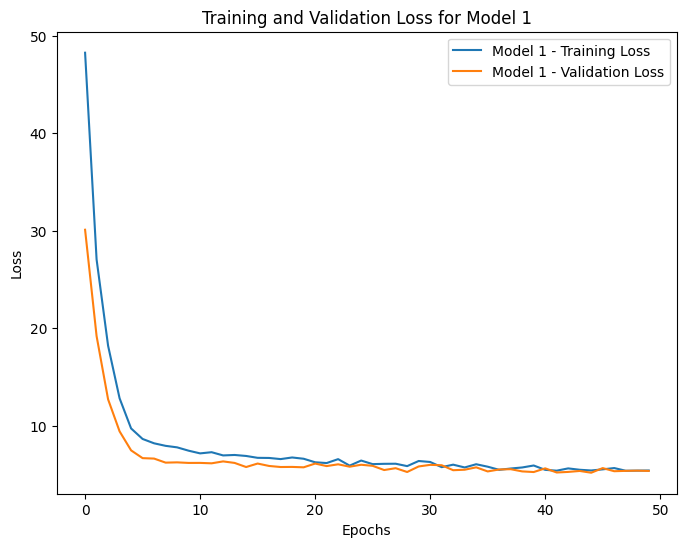

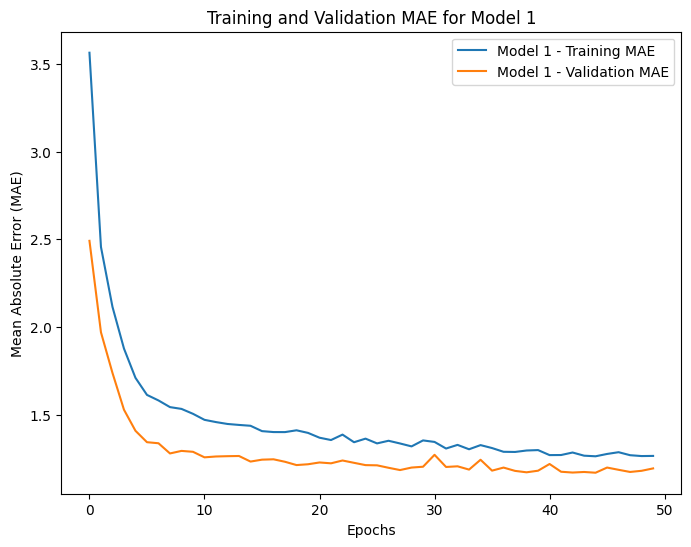

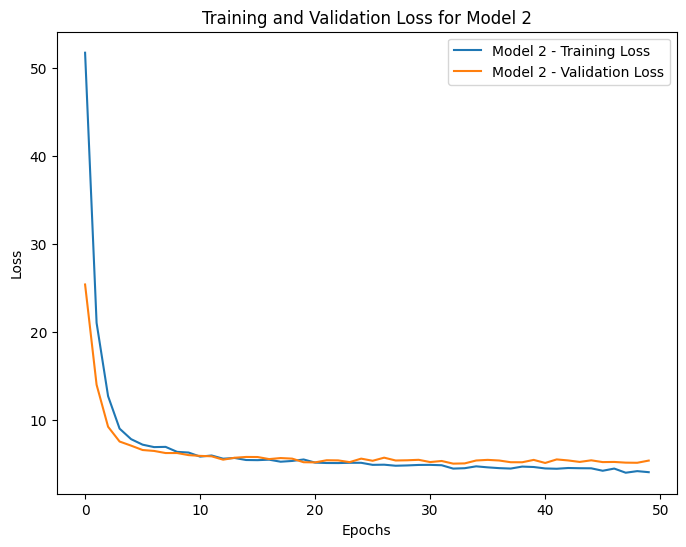

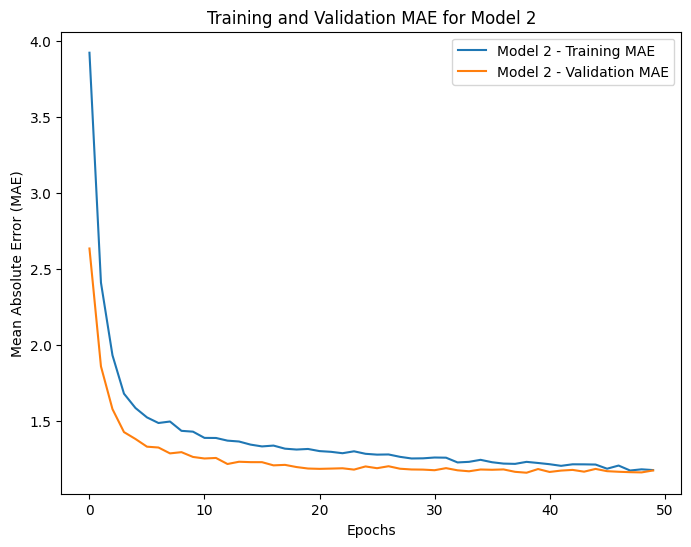

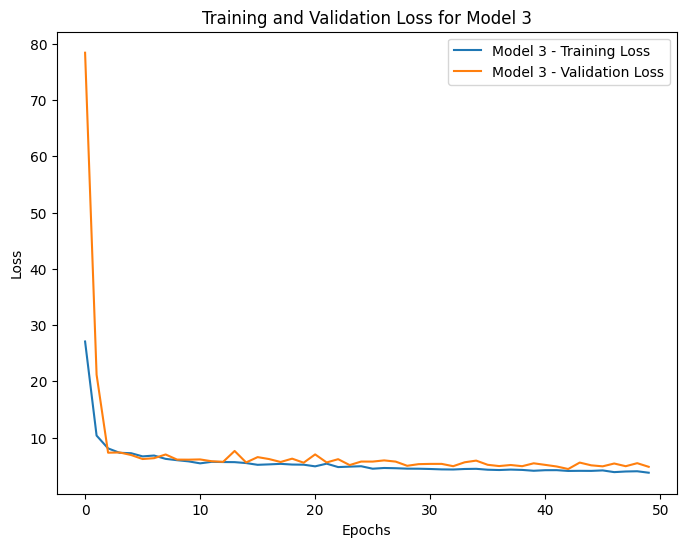

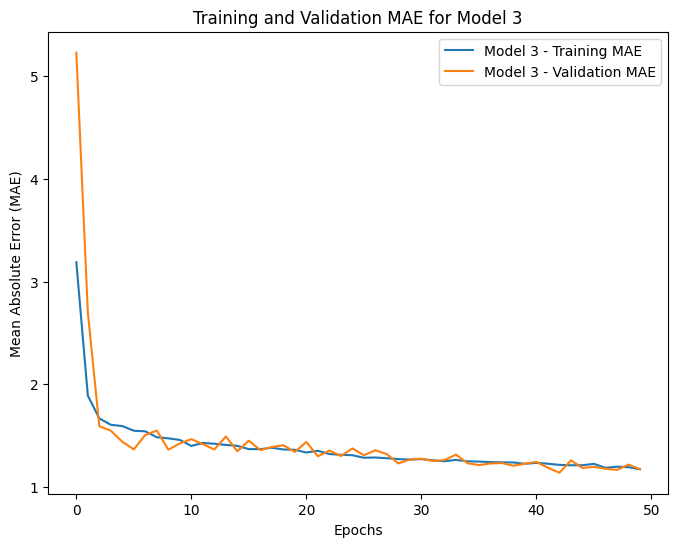

In [ ]:
import matplotlib.pyplot as plt

# Function to plot training and validation loss for a single model
def plot_loss_single(history, model_name):
    """
    Plots the training and validation loss over epochs for a given model.

    Parameters:
    - history: Keras History object containing training metrics
    - model_name: Name of the model for display in the plot
    """
    plt.figure(figsize=(8, 6))  # Set the figure size for the plot
    plt.plot(history.history['loss'], label=f'{model_name} - Training Loss')  # Plot training loss
    plt.plot(history.history['val_loss'], label=f'{model_name} - Validation Loss')  # Plot validation loss

    # Set plot labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss for {model_name}')
    plt.legend()  # Display legend to differentiate training and validation lines
    plt.show()    # Display the plot

# Function to plot training and validation Mean Absolute Error (MAE) for a single model
def plot_mae_single(history, model_name):
    """
    Plots the training and validation MAE over epochs for a given model.

    Parameters:
    - history: Keras History object containing training metrics
    - model_name: Name of the model for display in the plot
    """
    plt.figure(figsize=(8, 6))  # Set the figure size for the plot
    plt.plot(history.history['mae'], label=f'{model_name} - Training MAE')  # Plot training MAE
    plt.plot(history.history['val_mae'], label=f'{model_name} - Validation MAE')  # Plot validation MAE

    # Set plot labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title(f'Training and Validation MAE for {model_name}')
    plt.legend()  # Display legend to differentiate training and validation lines
    plt.show()    # Display the plot

# Assuming history_1, history_2, and history_3 are the history objects from training three different models

# Plot training and validation loss and MAE for Model 1
plot_loss_single(history_1, 'Model 1')
plot_mae_single(history_1, 'Model 1')

# Plot training and validation loss and MAE for Model 2
plot_loss_single(history_2, 'Model 2')
plot_mae_single(history_2, 'Model 2')

# Plot training and validation loss and MAE for Model 3
plot_loss_single(history_3, 'Model 3')
plot_mae_single(history_3, 'Model 3')


In [ ]:
import pandas as pd

# Extract the training, validation loss, MAE, and Kappa scores for each model
train_loss_1 = history_1.history['loss'][-1]
val_loss_1 = history_1.history['val_loss'][-1]
train_mae_1 = history_1.history['mae'][-1]
val_mae_1 = history_1.history['val_mae'][-1]
kappa_1 = kappa_1

train_loss_2 = history_2.history['loss'][-1]
val_loss_2 = history_2.history['val_loss'][-1]
train_mae_2 = history_2.history['mae'][-1]
val_mae_2 = history_2.history['val_mae'][-1]
kappa_2 = kappa_2

train_loss_3 = history_3.history['loss'][-1]
val_loss_3 = history_3.history['val_loss'][-1]
train_mae_3 = history_3.history['mae'][-1]
val_mae_3 = history_3.history['val_mae'][-1]
kappa_3 = kappa_3

# Create a DataFrame to organize these values for comparison
comparison_df = pd.DataFrame({
    'Metric': ['Training Loss', 'Validation Loss', 'Training MAE', 'Validation MAE', 'Quadratic Kappa'],
    'Model 1': [train_loss_1, val_loss_1, train_mae_1, val_mae_1, kappa_1],
    'Model 2': [train_loss_2, val_loss_2, train_mae_2, val_mae_2, kappa_2],
    'Model 3': [train_loss_3, val_loss_3, train_mae_3, val_mae_3, kappa_3]
})

# Format the DataFrame to improve readability
comparison_df.set_index('Metric', inplace=True)

# Optional: Apply styling for visual appeal (e.g., highlight the best results)
styled_df = comparison_df.style.highlight_min(axis=1, props='font-weight:bold; color:blue') \
                              .highlight_max(axis=1, props='font-weight:bold; color:red')

# Display the styled DataFrame
styled_df


,Model 1,Model 2,Model 3
Metric,,,
Training Loss,5.418590,4.114285,3.748166
Validation Loss,5.377004,5.430797,4.796678
Training MAE,1.264398,1.176214,1.172076
Validation MAE,1.193138,1.173747,1.171581
Quadratic Kappa,0.963014,0.963409,0.967530


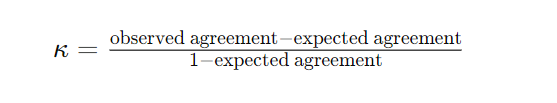

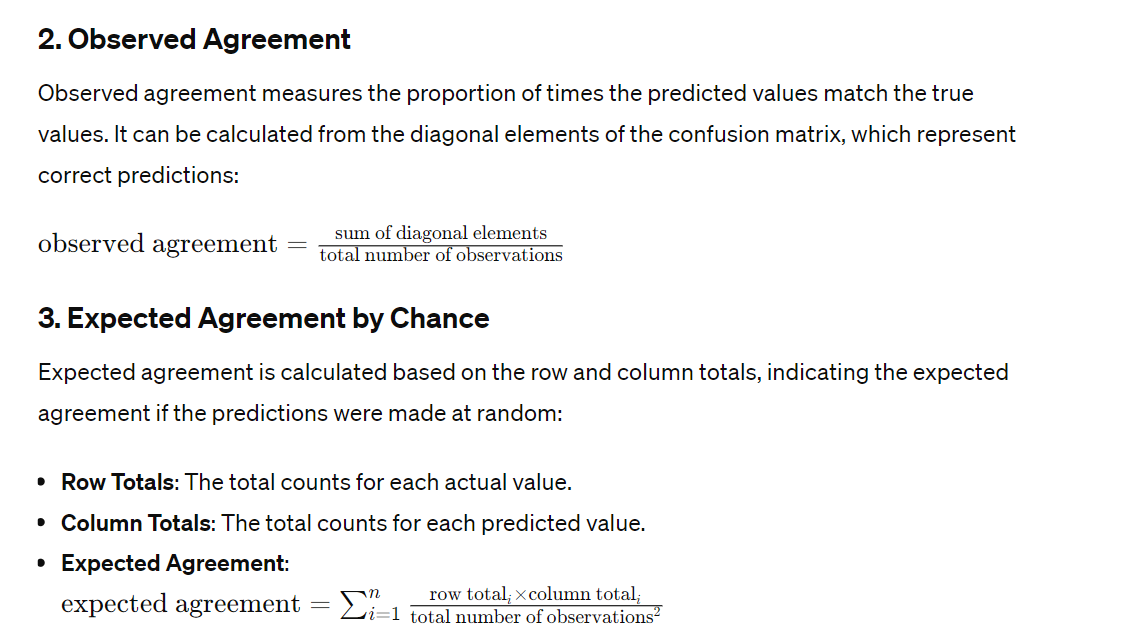